<div style="font-size: 40pt; font-weight: bold; padding: 40px 0 20px 0">Energy Function Training</div>

**by Eric Klavins**

Copyright &copy; 2019, University of Washington

**Abstract**: The Hydrophobic-polar (HP) protein folding model is a simplified 2D model of protein folding that was used to show that tasks such as findinfg the minimum eneryg conformation of a protein are NP-Hard. Here, we learn the energy function of the HP model, training it on conformations found during MCMC optimiztion.

# Includes

In [1]:
from __future__ import print_function

import math
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import namedtuple
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from hp import HP
from translate import Translate, Encoder, Decoder
from energy import Energy
from memory import Memory

%matplotlib inline

dev = "cuda:0"

# Training

In [2]:
def add_to_memory(mem, n):
    for _ in range(n):
        hp = HP.random(SEQUENCE_LENGTH)
        mem.push(hp.one_hot(dev=dev), hp.conf_one_hot(dev=dev))
    return mem

def hp_step(mem,idx):
    for i in idx:
        hp = HP.create_from_one_hots(mem.sequences[i], mem.conformations[i])
        hp.minimize_step()
        mem.conformations[i] = hp.conf_one_hot(dev=dev)    
        
def randomize_a_conformation(mem):
    i = random.randint(0,len(mem)-1)
    hp = HP.create_from_one_hots(mem.sequences[i], mem.conformations[i])
    hp.randomize_conf()
    mem.conformations[i] = hp.conf_one_hot(dev=dev) 

In [3]:
EPISODES = 100000
SEQUENCE_LENGTH = 20
LR = 0.0001
MEM_SIZE = 1000
BATCH_SIZE = 50
MIN_STEP_PROB = 0.25
REPLACE_PROB = 0.1
REPLACE_SIZE = 5

energy = Energy(SEQUENCE_LENGTH)
energy.to(dev)

energy_optimizer = optim.Adam(energy.parameters(), lr=LR)
mse_loss = nn.MSELoss()

losses = []

memory = Memory(MEM_SIZE)
add_to_memory(memory, MEM_SIZE)
    
for i in range(EPISODES):
    
    idx, sequences, conformations = memory.sample(BATCH_SIZE)
    
    # Find actual energies
    energies = torch.tensor([
        HP.create_from_one_hots(s,c).energy() for s,c in zip(sequences, conformations)]
        ,dtype=torch.float,device=dev)
    energies = energies.unsqueeze(1)

    # Predict the energies of the conformations
    inputs = energy.combine(sequences,conformations)
    estimates = energy(inputs)

    # Compute loss and take a gradient step
    loss = mse_loss(estimates, energies)
    energy_optimizer.zero_grad()
    loss.backward()
    energy_optimizer.step()
    
    # Take a minimization step
    if random.random() < MIN_STEP_PROB:
        hp_step(memory, idx)
    
    # Add some new sequences (dsiplacing old ones)
    if random.random() < REPLACE_PROB:
        add_to_memory(memory, REPLACE_SIZE)
        randomize_a_conformation(memory)
    
    # Report
    sys.stdout.write("\r%d: Loss: %f    " % (i+1,loss))
    losses.append(loss)


100000: Loss: 0.535174    

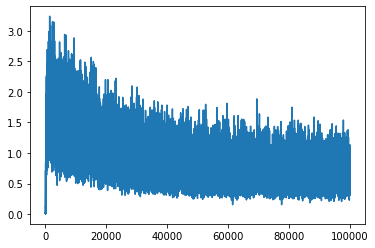

In [4]:
plt.plot(losses)
# plt.ylim(-10,10)

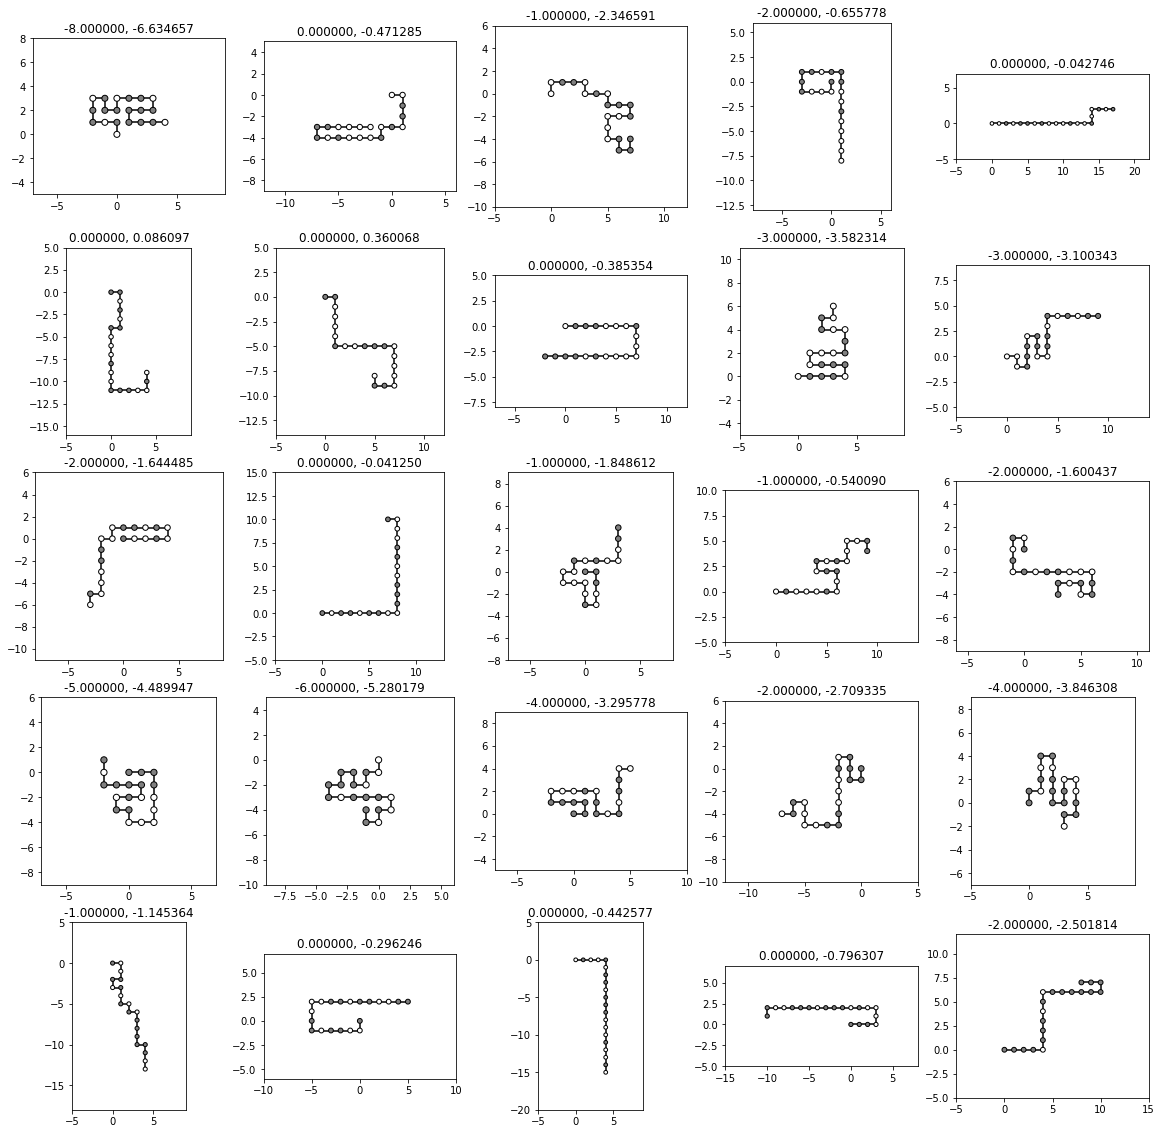

In [27]:
fig,ax = plt.subplots(5,5,figsize=(20,20))
idx, sequences, conformations = memory.sample(BATCH_SIZE)
inputs = energy.combine(sequences,conformations)
estimates = energy(inputs)
for i in range(25):
    hp = HP.create_from_one_hots(sequences[i], conformations[i])
    hp.show(ax[int(i/5),i%5])
    ax[int(i/5),i%5].set_title("%f, %f" % (hp.energy(), estimates[i]))

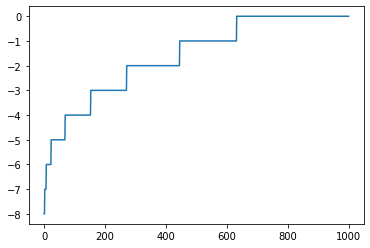

In [28]:
elist = [HP.create_from_one_hots(memory.sequences[i], memory.conformations[i]).energy() for i in range(MEM_SIZE)]
plt.plot(np.sort(elist));

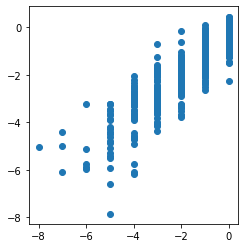

In [21]:
idx, sequences, conformations = memory.sample(10*BATCH_SIZE)
inputs = energy.combine(sequences,conformations)
estimates = energy(inputs)
energies = [HP.create_from_one_hots(sequences[i], conformations[i]).energy() for i in range(10*BATCH_SIZE)]
plt.scatter(energies,estimates.cpu().detach().numpy().flatten())
plt.gca().set_aspect(1)